In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import joblib
import warnings
from sklearn.exceptions import ConvergenceWarning

In [ ]:
# Suppress convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Load the dataset
df = pd.read_csv('timetable_data.csv')

# Preview the first few rows
print(df.head())

  Course_ID Instructor_ID Room_ID  Day Start_Time End_Time  Clash
0    CSE105          I006      R1  Fri      12:00    12:30      0
1    CSE104          I008      R4  Tue      16:30    17:30      0
2    CSE100          I001      R3  Tue      12:00    13:00      0
3    CSE103          I004      R4  Tue      09:30    10:30      0
4    CSE103          I004      R2  Tue      16:00    17:00      0


Class Distribution:
Clash
0    169
1     31
Name: count, dtype: int64

Class Percentages:
Clash
0    84.5
1    15.5
Name: proportion, dtype: float64


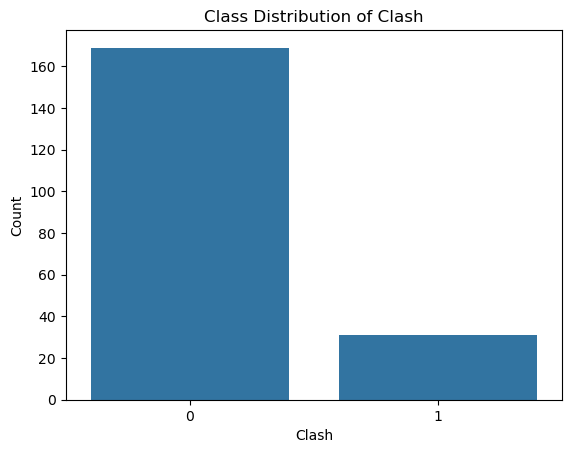

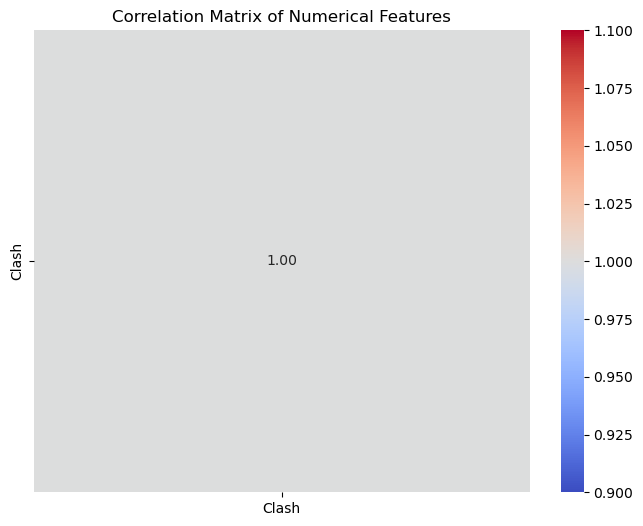

In [ ]:
#Exploratory Data Analysis
class_counts = df['Clash'].value_counts()
class_percentages = df['Clash'].value_counts(normalize=True) * 100

print("Class Distribution:")
print(class_counts)
print("\nClass Percentages:")
print(class_percentages)

# Plotting the class distribution
sns.countplot(x='Clash', data=df)
plt.title('Class Distribution of Clash')
plt.xlabel('Clash')
plt.ylabel('Count')
plt.show()

# Selecting numerical features for correlation
numerical_features = df.select_dtypes(include=['int64', 'float64'])

# Computing the correlation matrix
correlation_matrix = numerical_features.corr()

# Plotting the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [ ]:
# Convert Start_Time and End_Time to datetime
df['Start_Time'] = pd.to_datetime(df['Start_Time'], format='%H:%M')
df['End_Time'] = pd.to_datetime(df['End_Time'], format='%H:%M')

# Feature Engineering: Extract hour and minute
df['Start_Hour'] = df['Start_Time'].dt.hour
df['Start_Minute'] = df['Start_Time'].dt.minute
df['End_Hour'] = df['End_Time'].dt.hour
df['End_Minute'] = df['End_Time'].dt.minute

In [ ]:
# Drop original time columns
df.drop(['Start_Time', 'End_Time'], axis=1, inplace=True)

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, columns=['Course_ID', 'Instructor_ID', 'Room_ID', 'Day'])

# Separate features and target
X = df_encoded.drop('Clash', axis=1)
y = df_encoded['Clash']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'saga'],
    'penalty': ['l1', 'l2'],
    'max_iter': [1000, 5000]
}

grid_search = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Best model
best_model = grid_search.best_estimator_
print("\nBest Hyperparameters: ",best_model)


Best Hyperparameters:  LogisticRegression(C=0.1, max_iter=1000, penalty='l1', random_state=42,
                   solver='liblinear')


Confusion Matrix:
[[32  0]
 [ 8  0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        32
           1       0.00      0.00      0.00         8

    accuracy                           0.80        40
   macro avg       0.40      0.50      0.44        40
weighted avg       0.64      0.80      0.71        40



c:\Users\nishk\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nishk\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nishk\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


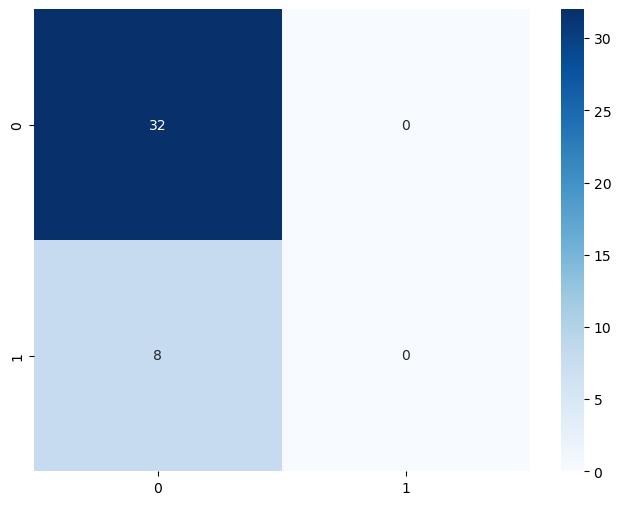

In [ ]:
# Evaluation
y_pred = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Confusion Matrix and Classification Report
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

#Plot confusion matrix
plt.figure(figsize=(8, 6))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Display the plot
plt.show()

ROC-AUC Score: 0.47


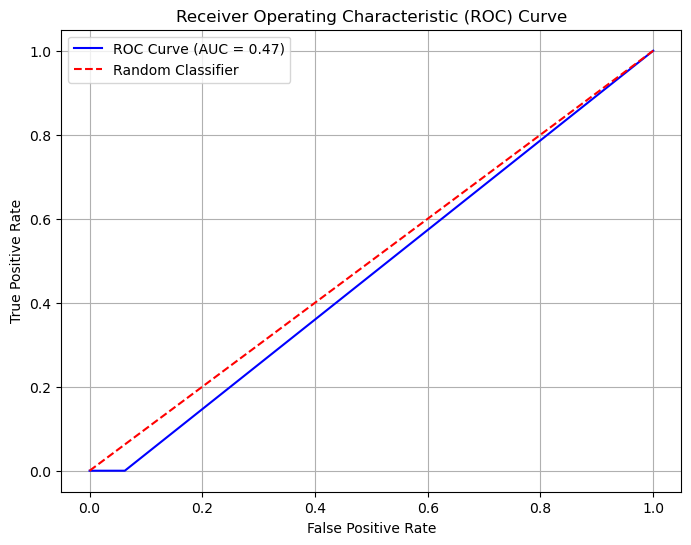

['scaler.pkl']

In [ ]:
# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc:.2f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()

# Save the model and scaler
joblib.dump(best_model, 'logistic_model.pkl')
joblib.dump(scaler, 'scaler.pkl')


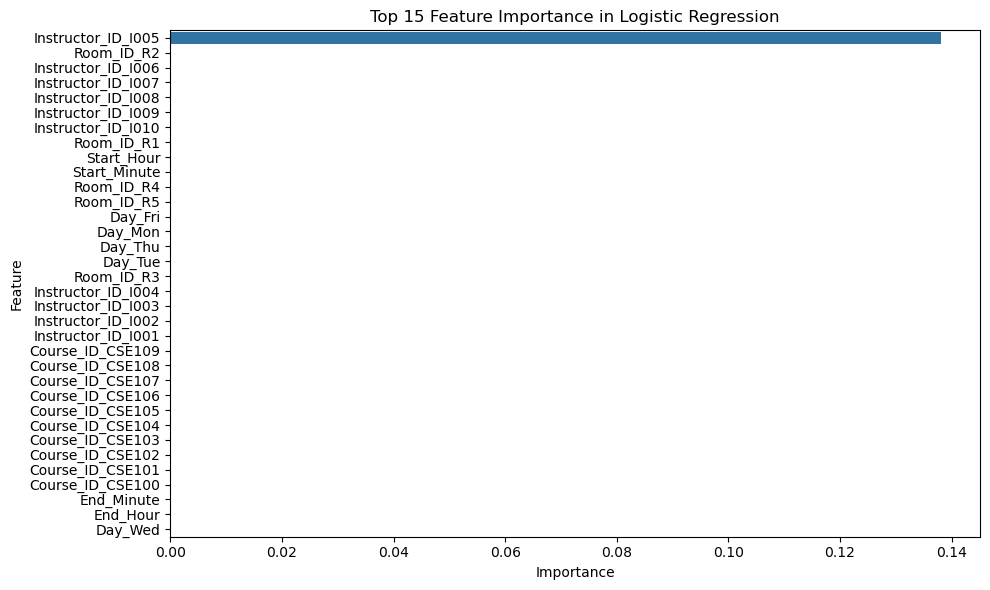

In [ ]:
# Extract feature names
feature_names = X.columns

# Get coefficients
coefficients = best_model.coef_[0]

# Create a DataFrame for visualization
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': np.abs(coefficients)
})

# Sort features by importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)


# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Top 15 Feature Importance in Logistic Regression')
plt.tight_layout()
plt.show()

In [ ]:
# Example new schedule data
new_schedule = pd.DataFrame({
    'Course_ID': ['CSE105'],
    'Instructor_ID': ['I003'],
    'Room_ID': ['R3'],
    'Day': ['Tuesday'],
    'Start_Time': ['10:00'],
    'End_Time': ['17:30']
})

# Convert times to datetime
new_schedule['Start_Time'] = pd.to_datetime(new_schedule['Start_Time'])
new_schedule['End_Time'] = pd.to_datetime(new_schedule['End_Time'])

# Calculate duration and time in minutes
new_schedule['Duration'] = (new_schedule['End_Time'] - new_schedule['Start_Time']).dt.total_seconds() / 60
new_schedule['Start_Minutes'] = new_schedule['Start_Time'].dt.hour * 60 + new_schedule['Start_Time'].dt.minute
new_schedule['End_Minutes'] = new_schedule['End_Time'].dt.hour * 60 + new_schedule['End_Time'].dt.minute

# One-hot encode categorical variables
new_schedule_encoded = pd.get_dummies(new_schedule, columns=['Course_ID', 'Instructor_ID', 'Room_ID', 'Day'])

# Align the new data with the training data columns
missing_cols = set(X.columns) - set(new_schedule_encoded.columns)
for col in missing_cols:
    new_schedule_encoded[col] = 0
new_schedule_encoded = new_schedule_encoded[X.columns]

# Predict clash
clash_prediction = grid_search.predict(new_schedule_encoded)
clash_probability = grid_search.predict_proba(new_schedule_encoded)[:, 1]

# Output
print(f"Clash Prediction: {clash_prediction[0]}")
print(f"Clash Probability: {clash_probability[0]:.2f}")


Clash Prediction: 0
Clash Probability: 0.21


c:\Users\nishk\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\nishk\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
